In [70]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

In [2]:
import ccxt

In [3]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    opens = pd.DataFrame(dataframes[0].open).rename(columns={'open':labels[0]})
    for i,coin in enumerate(labels[1:]):
        temp_opens = pd.DataFrame(dataframes[i+1].open).rename(columns={'open':coin})
        opens = opens.merge(temp_opens,how='outer',on='timestamp')
    return (opens)

def load_crypto(days=1000,timeframe='1h',n=30):
    bnc = ccxt.binance()
    symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,since/1000)
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i,:]/price_arr[i-1,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i,:]/price_arr[i-1,:])
    log_returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

In [4]:
crypto_data = pd.read_csv("https://raw.githubusercontent.com/louis-stp/CryptoPortfolio/main/CryptoPrices")
crypto_data['timestamp'] = crypto_data['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))
crypto_data.set_index("timestamp", inplace=True)
crypto_data = crypto_data.loc[:,crypto_data.columns[crypto_data.isna().sum(axis=0)<15000]]
nona = crypto_data.dropna().pct_change()[1:]

In [5]:
training = nona[:7000]
testing = nona[7000:]

In [6]:
regressor = 'BTC'
tickers = list(set(training.columns)-set([regressor]))

In [7]:
X = np.array(training[regressor]).reshape(-1,1)
y = np.array(training[tickers]).reshape(-1,len(tickers)) #second number is the number of stocks I think

In [8]:
#use all data as training data because we arn't predicting anything
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [9]:
coins = {k: [] for k in tickers}
for n in range(len(tickers)):
    lm.fit(X,y[:,n])
    coins[tickers[n]].append(lm.coef_[0])
    coins[tickers[n]].append(lm.score(X,y[:,n]))
    coins[tickers[n]].append(lm.intercept_)

In [10]:
pd.DataFrame(coins, index = ['BTC Beta','R^2','Alpha']).T

,BTC Beta,R^2,Alpha
BCH,1.087504,0.502157,-0.000024
ALGO,1.047170,0.352106,0.000055
FIL,0.783210,0.012161,0.000744
DOT,1.154612,0.437222,0.000098
AVAX,1.152252,0.320419,0.000103
DOGE,1.013253,0.129700,0.000750
THETA,1.102439,0.339383,0.000230
XRP,1.060069,0.281926,0.000107
UNI,1.170055,0.399428,0.000184
BNB,0.982211,0.425323,0.000224


form mean-variance optimized

In [11]:
#should really resample to daily data
t = 1 #number to makes std and means equivelent to yearly returns so 12 for monthly, 52 for weekly and 252 for daily
posLB = -.1  #lower bound on position exposure
posUB = .5  #upper bound on position exposure

muf = pd.Series(0)
returns = training
mean_vect = training.mean() * t

In [12]:
from scipy.optimize import linprog
m = len(training.columns)
#set equality constraints. I want my positions to sum to 1
A_eq = np.array((1,)*m).reshape(1,-1)
b_eq = [1]

# set bounds on leverage. We can short but we can not go long
short_bounds = (posLB,)*m
long_bounds = (posUB,)*m

bounds = np.vstack([short_bounds,long_bounds]).T

In [13]:
table_min = linprog(c=mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
print("weights",table_min.x)
min_rtn = mean_vect @ table_min.x
print("min rtn", min_rtn)

weights [ 0.49999999 -0.09999999 -0.09999999 -0.1        -0.09999999 -0.09999999
 -0.09999999 -0.1        -0.1        -0.09999999 -0.09999999  0.49999996
  0.4999999  -0.1        -0.09999986  0.49999996 -0.09999999 -0.09999999
  0.09999997 -0.1        -0.09999999  0.49999998]
min rtn -0.00023361343600839646


In [14]:
table_max = linprog(c=-mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
print("weights",table_max.x)
max_rtn = mean_vect @ table_max.x
print("max rtn", max_rtn)

weights [-0.09999999 -0.09999998 -0.09999998  0.49999989  0.09999983 -0.09999998
 -0.09999998  0.49999999  0.49999997 -0.09999998 -0.09999998 -0.09999999
 -0.09999999  0.49999998 -0.09999998 -0.09999999 -0.09999999 -0.09999998
 -0.09999998  0.49999998 -0.09999989 -0.09999999]
max rtn 0.0015468224602758851


In [15]:
returns

,BTC,ETH,BNB,SOL,ADA,XRP,DOT,DOGE,LUNA,AVAX,...,LTC,MATIC,ALGO,BCH,VET,XLM,ATOM,FIL,THETA,TRX
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-15 14:00:00,0.007050,0.008534,0.005600,0.014522,0.009051,0.009383,0.011382,0.005305,0.002459,0.008423,...,0.008713,0.008762,0.011450,0.011842,0.009598,0.014133,0.011613,5.611240,0.012257,0.005669
2020-10-15 15:00:00,0.000486,-0.004231,-0.004530,0.001795,-0.004392,-0.003557,-0.004733,0.000770,0.000613,-0.001083,...,-0.004821,0.000000,-0.000314,-0.006138,-0.001992,-0.002841,0.000706,-0.152965,0.008407,-0.003006
2020-10-15 16:00:00,0.004691,0.004541,0.001978,0.003670,0.001877,0.000487,0.005726,0.000616,0.004597,-0.000626,...,0.001009,0.004053,0.000629,0.001956,-0.004082,0.000271,0.036004,0.054184,-0.003556,-0.001885
2020-10-15 17:00:00,0.001913,0.004996,-0.001546,0.001219,0.004684,0.000122,-0.001544,0.000923,-0.003661,-0.005449,...,0.000403,-0.005767,0.000000,0.002603,0.003006,0.000000,-0.010562,0.219640,0.003367,0.001888
2020-10-15 18:00:00,-0.004333,-0.005602,-0.004053,-0.012131,-0.007739,-0.004702,-0.009641,-0.002306,-0.002449,0.000339,...,-0.003830,-0.005220,-0.013832,-0.004735,-0.005449,-0.004069,-0.006715,-0.254675,0.000144,-0.001508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-03 06:00:00,0.003193,0.005925,0.000992,0.008675,0.005183,0.004905,0.000697,0.002634,0.044720,0.000870,...,0.006253,0.003233,0.008858,0.005938,0.004305,0.006396,0.007254,0.002785,0.003524,-0.003271
2021-08-03 07:00:00,0.001726,0.005042,0.002106,0.009258,0.002309,0.000000,0.001801,0.004294,0.018536,0.002923,...,0.001012,0.002295,0.009646,0.001053,0.002500,-0.001884,0.000000,-0.002407,0.003687,-0.000781
2021-08-03 08:00:00,-0.005763,-0.008946,-0.007757,0.017044,-0.006372,-0.008088,-0.006436,-0.005634,0.045265,-0.002284,...,-0.006063,-0.006480,-0.005022,-0.008037,-0.008195,-0.010736,-0.003642,-0.007053,-0.005423,-0.003910


In [30]:
from qpsolvers import solve_qp
muP = np.arange(min_rtn * .995,max_rtn * .995, .00001)
sdP = np.zeros(len(muP))
weights = np.zeros([len(muP),m])

Cov = 2*np.array(returns.cov())
q_vec = np.zeros(m).reshape(-1,)
G = np.zeros([m,m])
h = np.zeros(m)
A = np.vstack([np.array((1,)*m).reshape(1,-1),mean_vect])

In [31]:
for i in range(len(muP)):
    b = np.array([1,muP[i]])
    weights[i] = solve_qp(P=Cov, q = q_vec, G=G, h=h, A=A, b=b, lb = bounds[:,0], ub = bounds[:,1])
    sdP[i] = np.sqrt(weights[i] @ (Cov/2) @ weights[i]) * np.sqrt(t)

In [32]:
portfolios = pd.DataFrame({'Returns': muP, 'Volatility': sdP,})

for counter, symbol in enumerate(tickers):
    #print(counter, symbol)
    portfolios[symbol+' weight'] = [w[counter] for w in weights]
    
portfolios['Sharpe'] = (portfolios['Returns']-muf.values) / portfolios['Volatility'] #note using monthly returns and vol

In [33]:
tangent = portfolios.iloc[[portfolios.Sharpe.argmax()]]
min_var = portfolios.iloc[[portfolios.Volatility.argmin()]]
efficient_portfolios = portfolios[portfolios['Returns'] >= min_var.Returns.values[0]-.02] #the .02 is arbitrary to see a bit below the min var port too

Text(0.5, 1.0, 'Hourly Risk vs Return Tangency Portfolio')

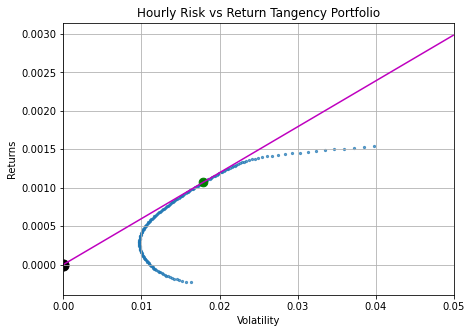

In [36]:
efficient_portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=5, alpha=0.7, grid=True, figsize=[7,5], xlim = (0,.05))
plt.scatter(0,muf, marker = '.',s=500, c = 'k')
plt.scatter(tangent.Volatility,tangent.Returns, marker = '.',s=300,c='g')
x = np.arange(0,.05,.0001)
plt.plot(x,tangent.Sharpe.values[0]*x+muf.values[0],c='m')
plt.title("Hourly Risk vs Return Tangency Portfolio")


In [75]:
tickers

['BCH',
 'ALGO',
 'FIL',
 'DOT',
 'AVAX',
 'DOGE',
 'THETA',
 'XRP',
 'UNI',
 'BNB',
 'ETH',
 'SOL',
 'LINK',
 'ADA',
 'VET',
 'XLM',
 'LTC',
 'LUNA',
 'ATOM',
 'TRX',
 'MATIC']

/var/folders/nr/w1vj30gx007c7ck0mr5ympx00000gn/T/ipykernel_28965/2734921035.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test = tangent.drop(["Returns","Volatility","Sharpe"],1)


Text(0.5, 1.0, 'Tangency Portfolio Weights per Cryptocurrency')

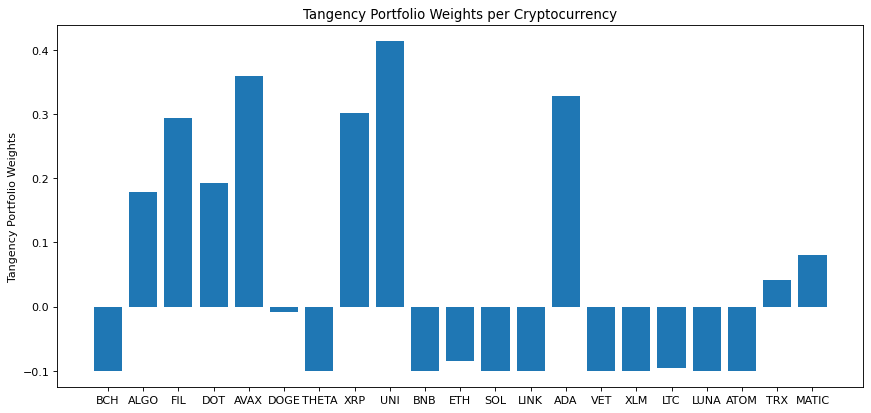

In [78]:
figure(figsize=(13, 6), dpi=80)
test = tangent.drop(["Returns","Volatility","Sharpe"],1)
plt.bar(tickers,np.squeeze(test.values))
plt.ylabel("Tangency Portfolio Weights")
plt.title("Tangency Portfolio Weights per Cryptocurrency")

In [40]:
weights

array([[ 0.5       , -0.1       , -0.1       , ..., -0.1       ,
        -0.1       ,  0.5       ],
       [ 0.5       , -0.1       , -0.1       , ..., -0.092425  ,
        -0.1       ,  0.5       ],
       [ 0.5       , -0.1       , -0.1       , ..., -0.07774479,
        -0.1       ,  0.5       ],
       ...,
       [-0.1       , -0.1       , -0.1       , ...,  0.430134  ,
        -0.1       , -0.1       ],
       [-0.1       , -0.1       , -0.1       , ...,  0.4540052 ,
        -0.1       , -0.1       ],
       [-0.1       , -0.1       , -0.1       , ...,  0.47787639,
        -0.1       , -0.1       ]])

In [22]:
min_var

,Returns,Volatility,BCH weight,ALGO weight,FIL weight,DOT weight,AVAX weight,DOGE weight,THETA weight,XRP weight,...,LINK weight,ADA weight,VET weight,XLM weight,LTC weight,LUNA weight,ATOM weight,TRX weight,MATIC weight,Sharpe
1,0.000768,0.013364,0.32277,0.227934,0.242534,0.128458,0.253742,0.009951,-0.1,0.186384,...,-0.1,0.186095,-0.1,-0.1,-0.089071,-0.043233,-0.1,0.027318,0.066449,0.057436


In [23]:
#https://pyportfolioopt.readthedocs.io/en/latest/

In [24]:
def correlation(dataset,SandP,day):
    return dataset.loc[day[0]:day[1]].corr()[SandP][1:]

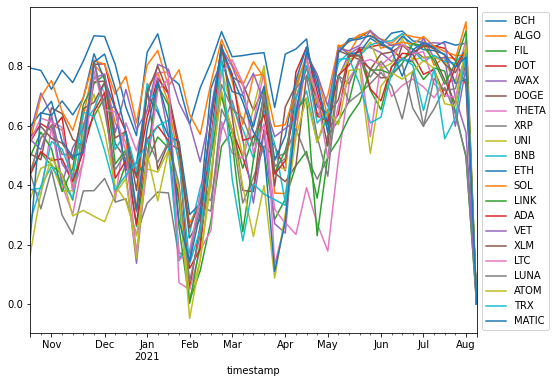

In [25]:
days = training.resample('W-MON').mean().index
corrs_mat = np.zeros([len(days),len(tickers)])
for n in range(len(days)-1):
    corrs_mat[n,:] = correlation(training,'BTC',days.astype(str)[n:n+2]).values
pd.DataFrame(corrs_mat,index=days,columns = tickers).plot(figsize=[8,6])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [26]:
import ccxt